## 🧬 LLM × Evolutionary Algorithms

### Learning objectives
- Practical — set up an LLM API (Gemini) and call it programmatically from Python.
- Technical — parse, compile and safely execute code emitted by an LLM.
- Research-oriented — evaluate LLM-generated meta-heuristics on a standard benchmark and iterate on them with simple evolutionary operators.
- Critical thinking — assess algorithmic ideas for correctness, novelty and computational efficiency.

### 1. Why are we doing this?

Modern Large Language Models (LLMs) are powerful tools that extend far beyond chatting. They can generate creative text, translate languages, write different kinds of content, and, importantly for us today, write code. We're going to explore how LLMs can be used to design new algorithms, drawing inspiration from how natural evolution works.

### 2. Environment setup
- Create / sign‑in to [Google AI Studio](https://aistudio.google.com/prompts/new_chat).
- Generate an API key and copy it

In [1]:
from google import genai
import os
from dotenv import load_dotenv

MODEL = "gemini-2.0-flash"

load_dotenv()

api_key = os.getenv("API_KEY")

client = genai.Client(api_key=api_key)

response = client.models.generate_content(
    model=MODEL,
    contents=["Hello, world!"]
)
print(response.text)

Hello there! How can I help you today?



If you see a greeting, you are good to go! 

### Why Gemini? 
We're using the Gemini API because it provides a generous free tier suitable for experimentation (e.g., 1500 free requests per day).

### 3. Large Language Models
The internal workings of LLMs are complex and beyond today's scope. For our purposes, we can treat an LLM as a sophisticated "text-to-text" function. A key strength of modern LLMs is their ability to understand and generate code in various programming languages. We'll leverage this today.


Let's start with a simple example:
> Problem: You are given a list of integers from 1 to n, with exactly one number missing. Write a Python function to find the missing number.


In [2]:
PROMPT = """
Problem: You are given a list of integers from 1 to n, with exactly one number missing. 
Write a Python function to find the missing number.
"""

response = client.models.generate_content(model=MODEL, contents=[PROMPT])
print(response.text)

```python
def find_missing_number(numbers):
  """
  Finds the missing number in a list of integers from 1 to n, with exactly one number missing.

  Args:
    numbers: A list of integers from 1 to n, with one number missing.

  Returns:
    The missing number.
  """
  n = len(numbers) + 1  # Determine the expected 'n' based on the length of the input list
  expected_sum = n * (n + 1) // 2  # Calculate the sum of numbers from 1 to n using the formula
  actual_sum = sum(numbers)  # Calculate the sum of the numbers in the input list

  return expected_sum - actual_sum  # The difference is the missing number

# Example usage:
numbers = [1, 2, 4, 6, 3, 7, 8]
missing_number = find_missing_number(numbers)
print(f"The missing number is: {missing_number}")  # Output: 5

numbers = [1, 2, 3, 5]
missing_number = find_missing_number(numbers)
print(f"The missing number is: {missing_number}") # Output: 4

numbers = [2, 3, 4, 5, 6]
missing_number = find_missing_number(numbers)
print(f"The missing numbe

This is a good start, but the LLM might return explanatory text along with the code, or the code might not be in a directly usable format. For systematic use, we need more control.

To make the LLM's output reliable for our task, we will:
1. Force a Specific Function Signature: We'll instruct the LLM to define a function with a name and parameters we choose.
2. Parse the Code: We'll extract the Python code from the LLM's response (which is often formatted in Markdown).
3. Verify and Execute: We'll compile the extracted code and then test it against predefined test cases.

In [3]:
PROMPT_WITH_SIGNATURE = """
Problem: You are given a list of integers from 1 to n, with exactly one number missing. 
Write a Python function to find the missing number.

Your solution should we wrapped in a Markdown Python block code. 
```python
def find_missing_number(numbers: list[int]) -> int:
    ...
```
"""

response = client.models.generate_content(model=MODEL, contents=[PROMPT_WITH_SIGNATURE])
print(response.text)

```python
def find_missing_number(numbers: list[int]) -> int:
    """
    You are given a list of integers from 1 to n, with exactly one number missing. 
    Write a Python function to find the missing number.
    """
    n = len(numbers) + 1
    expected_sum = n * (n + 1) // 2
    actual_sum = sum(numbers)
    return expected_sum - actual_sum
```


We can see that LLM was able to follow our instructions. Right now we need to parse the result:

In [4]:
import ast
import re
from typing import Any, Callable


class FunctionParser:
    @staticmethod
    def parse(
        model_response: str, function_name: str
    ) -> Callable[[list[int]], int] | None:
        function_str = FunctionParser.extract_code(model_response)
        if not function_str:
            print("No function found in response")
            return None

        if not FunctionParser.validate_function_syntax(function_str):
            print("Invalid function syntax")
            return None

        namespace: dict[str, Any] = {}
        # WARNING: This is not safe and should not be used in production
        # This should be run in a sandboxed environment
        exec(function_str, namespace)
        return namespace[function_name]

    @staticmethod
    def validate_function_syntax(function_str: str) -> bool:
        try:
            ast.parse(function_str)
            return True
        except SyntaxError:
            return False

    @staticmethod
    def extract_code(text: str) -> str | None:
        pattern = r"```python\s*(.*?)\s*```"
        match = re.search(pattern, text, re.DOTALL)
        return match.group(1) if match else None


function = FunctionParser.parse(response.text, "find_missing_number")

We can also verify if the result is correct:

In [5]:
assert function([1, 3, 4, 5]) == 2

We can implement automatic verification methods, including those that quantify the quality of our function. A simple yet effective metric is the percentage of test cases passed.

In [6]:
from typing import Generator
import random

class FunctionVerifier:
    def __init__(
        self,
        sizes: list[int] | None = None,
        *,
        rng_seed: int | None = None,
    ) -> None:
        self.sizes = sizes if sizes is not None else [5, 10, 20]
        self._rng = random.Random(rng_seed)

    def _test_cases(self) -> Generator[tuple[list[int], int], None, None]:
        for n in self.sizes:
            full = list(range(1, n + 1))
            for idx in range(n):
                data = full.copy()
                missing = data.pop(idx)
                self._rng.shuffle(data)
                yield data, missing

    def verify(
        self,
        func: Callable[[list[int]], int],
    ) -> float:
        solved = 0
        total = 0

        for data, expected in self._test_cases():
            try:
                result = func(data.copy())
                if result == expected:
                    solved += 1
            except Exception as e:
                print(f"Error during test case execution: {e}")
            total += 1

        return solved / total if total > 0 else 0.0


verifier = FunctionVerifier()
test_pass_rate = verifier.verify(function)
print(f"Test pass rate: {test_pass_rate:.2%}")

Test pass rate: 100.00%


So, we've established that LLMs can generate Python functions, and we can programmatically parse and verify their correctness. This forms the foundation for using LLMs in more complex algorithmic tasks, especially when combined with evolutionary approaches!

### 4. LLM × Evolutionary Algorithms

How can large language models be leveraged for optimization? One promising direction is to employ LLMs to generate novel optimization algorithms in much the same way they are used to synthesize problem-solving functions. Given that algorithms can be expressed as Python functions, this presents a natural and flexible framework for exploring algorithmic design via language models.

In [7]:
PROMPT_METAHEURISTIC = """
Problem: You are tasked with inventing a novel metaheuristic algorithm capable of minimizing an arbitrary real-valued, 
black-box, single-objective function defined over simple bound constraints.

Write a Python function that implements your algorithm. The function must take exactly these arguments:
- function: Callable[np.ndarray], float] - the objective function to minimise.
- bounds: list[tuple[float, float]] - a list of (lower, upper) pairs delimiting the search space for each dimension.
- budget: int - the total number of objective-function evaluations the algorithm may perform.

The function should return a tuple[float, np.ndarray] containing the best objective value found and the corresponding decision vector.

Your solution should be wrapped in a Markdown Python code block.

```python
import numpy as np 

def new_metaheuristic(
	function: Callable[[np.ndarray], float], 
    bounds: list[tuple[float, float]], 
    budget: int
) -> tuple[float, np.ndarray]:
    ...
```
"""

response = client.models.generate_content(model=MODEL, contents=[PROMPT_METAHEURISTIC])
print(response.text)

```python
import numpy as np
from typing import Callable, List, Tuple

def new_metaheuristic(
    function: Callable[[np.ndarray], float],
    bounds: List[Tuple[float, float]],
    budget: int
) -> Tuple[float, np.ndarray]:
    """
    Implements a simple metaheuristic algorithm for minimizing a black-box function
    subject to bound constraints. This algorithm uses a combination of random sampling
    and local search.

    Args:
        function: The objective function to minimize.  It takes a numpy array as input
                  and returns a float.
        bounds: A list of (lower, upper) pairs delimiting the search space for each dimension.
        budget: The total number of objective-function evaluations the algorithm may perform.

    Returns:
        A tuple containing the best objective value found and the corresponding decision vector.
    """

    dimension = len(bounds)
    best_value = float('inf')
    best_solution = None

    # Initial random sampling
    num_initia

### Exercise 1:
Describe the meta‑heuristic generated by Gemini. Does the idea make sense? Is it novel? What are its weaknesses? 

My explonation:
This idea makes sense. It focuses on finding local optima and then exploiting it for remaining numbers of iterations. This idea is not new, but it has some problems. This function will get stuck in first local minima. Budget for exploration is really small. I can see some implementation problems too. If our function outputs inf in many cases (weird case but technicly possible) and we will not find any good solution after exploration we will not use all our budget. Secound probles is that when we pass budget 0 (for example when our budget is calculated by external data) we will still perform 1 evaluation, so we will exeed our budget.

My explanation: \
This idea makes sense. It focuses on finding a local optimum and then exploiting it for the remaining number of iterations. While the idea is not new, it does have some issues. 

First, the function may get stuck in the first local minimum it encounters, and the exploration budget is very small. I also see some potential implementation problems. For example, if the function returns only inf during exploration (an unusual but technically possible scenario), we will end up not using the entire budget. 

A second issue arises when the budget is set to zero (e.g., if the budget is determined by external data). In this case, the function still performs one evaluation, which causes us to exceed the budget.

In [8]:
exercise_1_gemini = client.models.generate_content(model=MODEL, contents=[
    f"Describe this meta‑heuristic function in max 5 sentences. Does the idea make sense? Is it novel? What are its weaknesses? {response.text}"
])
print(exercise_1_gemini.text)

The function `new_metaheuristic` attempts to minimize a given function within specified bounds using a hybrid approach of random sampling and local search. It begins by generating a set of random initial solutions and then iteratively refines the best solution found so far by applying small, normally distributed perturbations and clipping the results to stay within the defined boundaries.  If no better solution is found after the initial sampling, it returns a random solution. The idea of combining global exploration (random sampling) with local exploitation (perturbation) is sound in principle. This implementation is likely not novel, as it's a fairly basic combination of common optimization strategies. A key weakness is its sensitivity to the perturbation scale, which needs careful tuning. Additionally, it may easily get stuck in local optima due to the simple local search strategy.



Gemini found one more weakness. I have not thought about a pertubation scale, but it is an important factor

Let's parse it:

In [9]:
metaheuristic = FunctionParser.parse(response.text, "new_metaheuristic")

And quantify its quality (average across 10 runs for Rastrigin in 10D):

In [13]:
import random
from typing import Callable, Generator

import numpy as np


def rastrigin(x: np.ndarray) -> float:
    A: float = 10.0
    return float(A * len(x) + np.sum(x**2 - A * np.cos(2 * np.pi * x)))


class OptimizerVerifier:
    def __init__(
        self,
        budget: int = 10_000,
        dims: int = 10,
        seeds_count: int = 10,
        test_function: Callable = rastrigin,
    ) -> None:
        self.budget = budget
        self.dims = dims
        self.seeds_count = seeds_count
        self.test_function = test_function

    def verify(
        self,
        optimizer: Callable,
    ) -> dict[str, float]:
        bounds = [(-5, 5) for _ in range(self.dims)]
        results = []
        for seed in range(self.seeds_count):
            np.random.seed(seed)
            random.seed(seed)
            best_val, _ = optimizer(self.test_function, bounds, self.budget)
            results.append(best_val)
        return np.mean(best_val)


verifier = OptimizerVerifier()
mean_score_for_rastrigin = verifier.verify(metaheuristic)
mean_score_for_rastrigin

np.float64(35.129372460515924)

Now let's go one step further. We can calculate the quality (fitness function) for each solution (metaheuristic) generated by LLM. In this case we can try to apply crossover/mutation operators to textual solutions. We can visualize it as optimization process in the space of Python functions that represent different optimization algorithms.

### Exercise 2:
Review [Evolution of Heuristics: Towards Efficient Automatic Algorithm Design Using Large Language Model](https://arxiv.org/pdf/2401.02051) and read **3.4 Prompt Strategies**. Re-implement one of the prompt strategies from **3.4 Prompt Strategies** of Evolution of Heuristics. Generate N = 5 distinct algorithms, benchmark them and report the best.

I have chosen M1 strategy

In [36]:
# M1
MY_PROMPT_METAHEURISTIC = """
Problem: You are tasked with inventing a novel metaheuristic algorithm capable of minimizing an arbitrary real-valued, 
black-box, single-objective function defined over simple bound constraints.

Write a Python function that implements your algorithm. The function must take exactly these arguments:
- function: Callable[np.ndarray], float] - the objective function to minimise.
- bounds: list[tuple[float, float]] - a list of (lower, upper) pairs delimiting the search space for each dimension.
- budget: int - the total number of objective-function evaluations the algorithm may perform.

The function should return a tuple[float, np.ndarray] containing the best objective value found and the corresponding decision vector.

Your solution should be wrapped in a Markdown Python code block. Describe your metaheuristic and its main steps in one sentence.

```python
import numpy as np 

def new_metaheuristic(
	function: Callable[[np.ndarray], float], 
    bounds: list[tuple[float, float]], 
    budget: int
) -> tuple[float, np.ndarray]:
    ...
```
"""

In [37]:
N = 5
response_tab = []
for _ in range(N):
    response = client.models.generate_content(model=MODEL, contents=[MY_PROMPT_METAHEURISTIC])
    response_tab.append(response.text)

In [38]:
for i, response in enumerate(response_tab):
    code = FunctionParser.parse(response, "new_metaheuristic")
    score = verifier.verify(code)
    print(f"For function number {i} we got mean {score=}")

For function number 0 we got mean score=np.float64(36.16660942847668)
For function number 1 we got mean score=np.float64(22.892855079512913)
For function number 2 we got mean score=np.float64(25.820659788977196)
For function number 3 we got mean score=np.float64(32.22946902572356)
For function number 4 we got mean score=np.float64(74.62595627873847)


In [40]:
best_function = response_tab[1]

In [41]:
MY_EVOLUTION_PROMPT = f"""
Problem: You are tasked with inventing a novel metaheuristic algorithm capable of minimizing an arbitrary real-valued, 
black-box, single-objective function defined over simple bound constraints.

Modify given function for better performance. You are given function code and its short description.

{best_function}

Write a new Python function called "new_metaheuristic" that implements your algorithm. The function must take exactly these arguments:
- function: Callable[np.ndarray], float] - the objective function to minimise.
- bounds: list[tuple[float, float]] - a list of (lower, upper) pairs delimiting the search space for each dimension.
- budget: int - the total number of objective-function evaluations the algorithm may perform.

The function should return a tuple[float, np.ndarray] containing the best objective value found and the corresponding decision vector.

Your solution should be wrapped in a Markdown Python code block. Describe your metaheuristic and main steps in one sentence.

```python
import numpy as np 

def new_metaheuristic(
	function: Callable[[np.ndarray], float], 
    bounds: list[tuple[float, float]], 
    budget: int
) -> tuple[float, np.ndarray]:
    ...
```
"""

In [42]:
evolution_response_tab = []
for _ in range(N):
    response = client.models.generate_content(model=MODEL, contents=[MY_EVOLUTION_PROMPT])
    evolution_response_tab.append(response.text)

In [43]:
for i, response in enumerate(evolution_response_tab):
    code = FunctionParser.parse(response, "new_metaheuristic")
    score = verifier.verify(code)
    print(f"For new function number {i} after evolution we got mean {score=}")

For new function number 0 after evolution we got mean score=np.float64(63.04826804408046)
For new function number 1 after evolution we got mean score=np.float64(14.978334012634917)
For new function number 2 after evolution we got mean score=np.float64(34.46995697673242)
For new function number 3 after evolution we got mean score=np.float64(22.98570092436917)
For new function number 4 after evolution we got mean score=np.float64(40.41633353541435)


Run one of these operators, and try to explain what happened? Are the new mutated solution better than previous one? Calculate the quality of new solution and old ones.

In [44]:
# best function before evolution
print(response_tab[1])

```python
import numpy as np
from typing import Callable, List, Tuple

def new_metaheuristic(
	function: Callable[[np.ndarray], float], 
    bounds: List[Tuple[float, float]], 
    budget: int
) -> Tuple[float, np.ndarray]:
    """
    Implements a simplified Differential Evolution algorithm for minimizing a black-box function subject to bound constraints.
    """
    dim = len(bounds)
    pop_size = min(100, budget // 10)  # Adjust population size based on budget
    mutation_factor = 0.5
    crossover_rate = 0.7

    population = np.random.rand(pop_size, dim)
    for i in range(dim):
        population[:, i] = bounds[i][0] + population[:, i] * (bounds[i][1] - bounds[i][0])
    
    fitness = np.array([function(x) for x in population])
    budget -= pop_size
    
    best_index = np.argmin(fitness)
    best_value = fitness[best_index]
    best_vector = population[best_index].copy()

    while budget > 0:
        for i in range(pop_size):
            # Mutation
            indices = [i

In [45]:
# best function after evolution
print(evolution_response_tab[1])

```python
import numpy as np
from typing import Callable, List, Tuple

def new_metaheuristic(
	function: Callable[[np.ndarray], float], 
    bounds: List[Tuple[float, float]], 
    budget: int
) -> Tuple[float, np.ndarray]:
    """
    Implements an enhanced Differential Evolution algorithm with adaptive parameters and a restart mechanism for minimizing a black-box function subject to bound constraints.
    """
    dim = len(bounds)
    pop_size = min(100, budget // 10)  # Adjust population size based on budget
    mutation_factor = 0.5
    crossover_rate = 0.7
    
    # Adaptive parameter settings
    mutation_factor_base = 0.5
    crossover_rate_base = 0.7
    mutation_factor_decay = 0.99
    crossover_rate_decay = 0.99

    population = np.random.rand(pop_size, dim)
    for i in range(dim):
        population[:, i] = bounds[i][0] + population[:, i] * (bounds[i][1] - bounds[i][0])
    
    fitness = np.array([function(x) for x in population])
    budget -= pop_size
    
    best_ind

Most of the new evolved solutions are worse. Only one is better. Evolution added mutation and crossover dacey and stagnation counter which helps avoid local minima. I have one small problem with stagnation counter. It overwrites the best solution found. If we found the best solution, we will overwrite it. It is unacceptable!

### Exercise 3:
Implement Evolution of Heuristics (or at least part of it). Start simple (pseudocode):
```
current_population = [generate_heuristic()]
for _ in range(10):
   parents = current_population[-p:]
   new_solution = E1(parents) # Read 3.4. Prompt Strategies to better understand E1
   f_new_solution = verify(new_solution)
   current_population.append(new_solution)
```
Save all solutions (best would be to have a separate file for each one). Analyse 5 different ones. Plot quality of solution per epoch. Is this iterative process converging?

In [47]:
p = 3

In [80]:
prompt_start = """
Problem: You are tasked with inventing a novel metaheuristic algorithm capable of minimizing an arbitrary real-valued, 
black-box, single-objective function defined over simple bound constraints. You are given few parent metaheuristic functions.
Generate new heuristic that is as much different as possible from parent heuristics. Remember to count the budget correctly. Avoid endless loops.

Parent heuristics:
"""

prompt_end = """
Write a new Python function called "new_metaheuristic" that implements your algorithm. The function must take exactly these arguments:
- function: Callable[np.ndarray], float] - the objective function to minimise.
- bounds: list[tuple[float, float]] - a list of (lower, upper) pairs delimiting the search space for each dimension.
- budget: int - the total number of objective-function evaluations the algorithm may perform.

The function should return a tuple[float, np.ndarray] containing the best objective value found and the corresponding decision vector.

Your solution should be wrapped in a Markdown Python code block. Describe steps of your new metaheuristic in one sentence.

```python
import numpy as np 

def new_metaheuristic(
	function: Callable[[np.ndarray], float], 
    bounds: list[tuple[float, float]], 
    budget: int
) -> tuple[float, np.ndarray]:
    ...
```
"""

In [81]:
def generate_prompt_from_parents(parents):
    tab = [prompt_start]
    for i, parent in enumerate(parents):
        tab.append(f"parent number {i}:")
        tab.append(parent)
    tab.append(prompt_end)
    
    return "\n".join(tab)

In [84]:
current_population = [client.models.generate_content(model=MODEL, contents=[MY_PROMPT_METAHEURISTIC]).text]
scores_tab = []

In [85]:
score = verifier.verify(FunctionParser.parse(current_population[0], "new_metaheuristic"))
scores_tab.append(score)
print(f"First function score is {score}")

First function score is 39.80718053905843


In [86]:
for i in range(10):
    parents = current_population[-p:]
    new_solution = client.models.generate_content(model=MODEL, contents=[generate_prompt_from_parents(parents)]).text
    score = verifier.verify(FunctionParser.parse(new_solution, "new_metaheuristic"))
    scores_tab.append(score)
    print(f"Solution number {i} got mean {score=}")
    current_population.append(new_solution)

Solution number 0 got mean score=np.float64(95.82095750602372)
Solution number 1 got mean score=np.float64(7.04840295215152)
Solution number 2 got mean score=np.float64(0.050972573117789466)
Solution number 3 got mean score=np.float64(59.727473148302295)
Solution number 4 got mean score=np.float64(78.6020844222607)
Solution number 5 got mean score=np.float64(39.90156046571907)
Solution number 6 got mean score=np.float64(4.400989433832379)
Solution number 7 got mean score=np.float64(21.795153194566552)
Solution number 8 got mean score=np.float64(76.6132122590652)
Solution number 9 got mean score=np.float64(3.063520428708358)


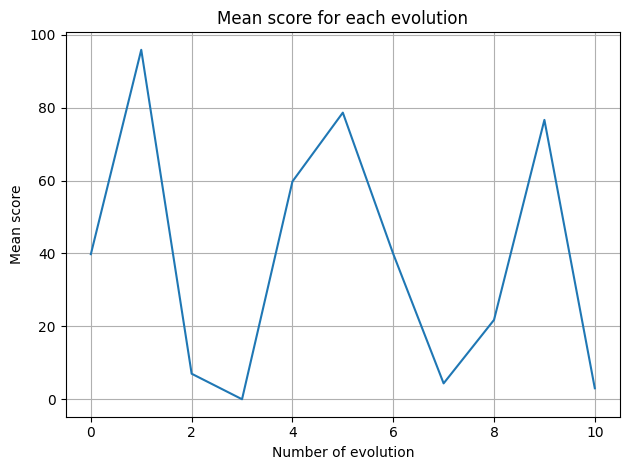

In [94]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(scores_tab)
plt.title("Mean score for each evolution")
plt.xlabel("Number of evolution")
plt.ylabel("Mean score")
plt.grid(True)
plt.tight_layout()
plt.show()

In [92]:
for i, sol in enumerate(current_population):
    with open(f"program_number_{i}.txt", "w") as f:
        f.write(FunctionParser.extract_code(sol))

In [95]:
small_verifier = OptimizerVerifier(seeds_count=1)

In [98]:
# program number 0
from typing import Callable, List, Tuple

def new_metaheuristic(
    function: Callable[[np.ndarray], float], 
    bounds: List[Tuple[float, float]], 
    budget: int
) -> Tuple[float, np.ndarray]:
    """
    Implements a simplified differential evolution algorithm to minimize a black-box function.
    """
    dim = len(bounds)
    population_size = min(10 * dim, budget // 2)  # Adjust population size based on budget
    population_size = max(population_size, 2)     # Ensure at least 2

    # Initialize population within bounds
    population = np.zeros((population_size, dim))
    for i in range(dim):
        population[:, i] = np.random.uniform(bounds[i][0], bounds[i][1], population_size)

    # Evaluate initial population
    fitness = np.array([function(x) for x in population])
    num_evaluations = population_size

    # Track best value
    best_index = np.argmin(fitness)
    best_value = fitness[best_index]
    best_solution = population[best_index].copy()

    # List to store best values over time for plotting
    best_values_over_time = [best_value]

    # DE parameters
    F = 0.8
    CR = 0.7

    # Main loop
    while num_evaluations < budget:
        for i in range(population_size):
            indices = np.random.choice(population_size, 3, replace=False)
            a, b, c = population[indices]

            mutant = a + F * (b - c)

            trial = population[i].copy()
            for j in range(dim):
                if np.random.rand() < CR:
                    trial[j] = mutant[j]

            # Repair: keep trial within bounds
            for j in range(dim):
                trial[j] = np.clip(trial[j], bounds[j][0], bounds[j][1])

            trial_fitness = function(trial)
            num_evaluations += 1

            if trial_fitness < fitness[i]:
                fitness[i] = trial_fitness
                population[i] = trial

                if trial_fitness < best_value:
                    best_value = trial_fitness
                    best_solution = trial.copy()

            # Track best value at each evaluation
            best_values_over_time.append(best_value)

            if num_evaluations >= budget:
                break

    # Plot best value over time
    plt.plot(best_values_over_time)
    plt.title("Convergence of Best Value for function number 0")
    plt.xlabel("Evaluation Step")
    plt.ylabel("Best Function Value Found")
    plt.grid(True)
    plt.show()

    return best_value, best_solution

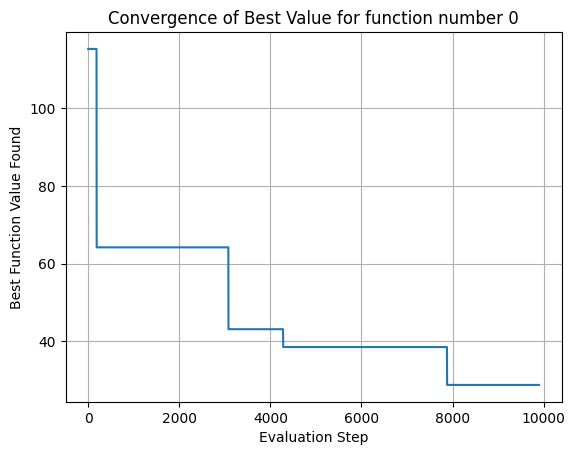

np.float64(28.763935236639114)

In [99]:
small_verifier.verify(new_metaheuristic)

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List, Tuple

def new_metaheuristic(
    function: Callable[[np.ndarray], float], 
    bounds: List[Tuple[float, float]], 
    budget: int
) -> Tuple[float, np.ndarray]:
    """
    Implements a simplified Harmony Search algorithm to minimize a black-box function.
    """
    dim = len(bounds)
    harmony_memory_size = min(10 * dim, budget // 2)
    harmony_memory_size = max(harmony_memory_size, 1)
    
    # Initialize Harmony Memory (HM)
    harmony_memory = np.zeros((harmony_memory_size, dim))
    for i in range(dim):
        harmony_memory[:, i] = np.random.uniform(bounds[i][0], bounds[i][1], harmony_memory_size)
    
    # Evaluate Harmony Memory
    harmony_fitness = np.array([function(x) for x in harmony_memory])
    num_evaluations = harmony_memory_size
    
    # Find best harmony
    best_index = np.argmin(harmony_fitness)
    best_value = harmony_fitness[best_index]
    best_solution = harmony_memory[best_index].copy()

    # List to track best value over time
    best_values_over_time = [best_value]
    
    # Harmony Search parameters
    HMCR = 0.9  # Harmony Memory Consideration Rate
    PAR = 0.3   # Pitch Adjustment Rate
    BW = 0.01   # Bandwidth (step size for pitch adjustment)

    # Main loop
    while num_evaluations < budget:
        # Improvise a new harmony
        new_harmony = np.zeros(dim)
        for i in range(dim):
            if np.random.rand() < HMCR:
                index = np.random.randint(0, harmony_memory_size)
                new_harmony[i] = harmony_memory[index, i]
                if np.random.rand() < PAR:
                    new_harmony[i] += np.random.uniform(-BW, BW)
            else:
                new_harmony[i] = np.random.uniform(bounds[i][0], bounds[i][1])
            
            new_harmony[i] = np.clip(new_harmony[i], bounds[i][0], bounds[i][1])
        
        new_fitness = function(new_harmony)
        num_evaluations += 1
        
        # Update Harmony Memory if better than worst
        worst_index = np.argmax(harmony_fitness)
        if new_fitness < harmony_fitness[worst_index]:
            harmony_fitness[worst_index] = new_fitness
            harmony_memory[worst_index] = new_harmony

            if new_fitness < best_value:
                best_value = new_fitness
                best_solution = new_harmony.copy()

        # Track best value after each evaluation
        best_values_over_time.append(best_value)

        if num_evaluations >= budget:
            break

    # Plot best value over time
    plt.plot(best_values_over_time)
    plt.title("Convergence of Best Value for function number 3")
    plt.xlabel("Evaluation Step")
    plt.ylabel("Best Function Value Found")
    plt.grid(True)
    plt.show()
    
    return best_value, best_solution

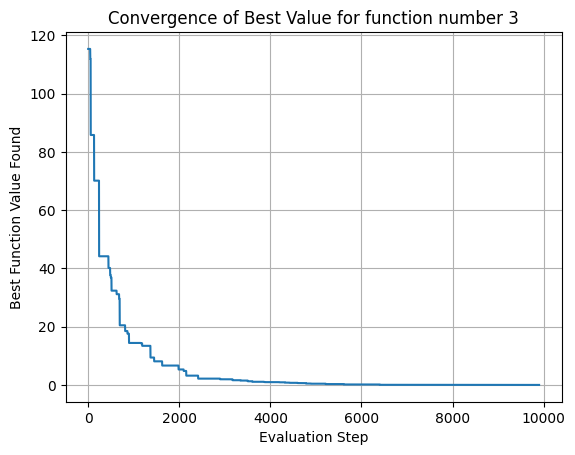

np.float64(0.006360606707431771)

In [101]:
small_verifier.verify(new_metaheuristic)

There is no noticeable improvement with an increased number of evolutions of our programs. This is because our prompt doesn't contain information about improving the program, but rather about changing it to be as different in approach from its parents as possible.

While testing this, I encountered several issues. Usually, testing a finished program took a few seconds, but sometimes there were cases where it took several minutes (or even ran indefinitely, though I would terminate the program after a few minutes). I had to add instructions to our prompt to avoid infinite loops and ensure that our budget is calculated correctly.

Solution 0 (ok): \
Starts by generating a random population of candidate solutions within specified bounds. In each iteration, it creates a new "trial" solution by mutating and recombining existing individuals. If a trial solution performs better than the current one, it replaces it in the population. \
It will exceed budget when initializing the population if budget is 0 or 1.

Solution 3 (the best one): \
This program searches for the minimum of a function using a simplified Harmony Search algorithm. It begins by randomly generating a set of candidate solutions called the Harmony Memory (HM). In each iteration, a new candidate "harmony" is improvised by either reusing values from HM or randomly generating new ones, with optional small adjustments (pitch adjustment).

Solution 5 (bad): \
This is just simulated annealing. It starts from a random point inside the search bounds and treats its objective value as the current “energy.” At each temperature level, it perturbs every coordinate by a small, temperature-scaled step, clips the result back into bounds, and evaluates the new energy. The new point is accepted if it improves the energy or with a probability exp(−ΔE / T) to allow occasional uphill moves that escape local minima. Temperature is geometrically cooled until it drops below a threshold or the evaluation budget is exhausted.

Solution 9 (bad): \
Simulated annealing with a re-annealing mechanism. Unlike the solution 5 when the temperature drops below a threshold and enough evaluations have passed, it resets the temperature to its initial value. This helps the algorithm escape local minima by reintroducing exploration.

Solution 10 (good): \
This program searches for the minimum of a function using a hybrid of Genetic Algorithms with tournament selection replacement. It starts with a randomly initialized population and evaluates their fitness. In each iteration, it selects individuals using tournament selection, performs crossover and mutation to create offspring, and then evaluates them. The worst individuals in the population are replaced by better-performing offspring, allowing gradual improvement.

### Call to Action
The GECCO 2025 conference is hosting a [competition](https://gecco-2025.sigevo.org/Competition?itemId=5104) on LLM-designed Evolutionary Algorithms. If you’re interested in collaborating and participating as a team, feel free to send me a direct message. Let’s explore the opportunity together.

### 5. Recommended Reading
- [AlphaEvolve: A Gemini-powered coding agent for designing advanced algorithms](https://deepmind.google/discover/blog/alphaevolve-a-gemini-powered-coding-agent-for-designing-advanced-algorithms/)
- Shojaee, Parshin, et al. [LLM-SR: Scientific equation discovery via programming with large language models.](https://arxiv.org/abs/2404.18400)
- Romera-Paredes, Bernardino, et al. [Mathematical discoveries from program search with large language models.](https://www.nature.com/articles/s41586-023-06924-6)
- van Stein, Niki, and Thomas Bäck. [Llamea: A large language model evolutionary algorithm for automatically generating metaheuristics.](https://arxiv.org/abs/2405.20132)
- Liu, Fei, et al. [Evolution of heuristics: Towards efficient automatic algorithm design using large language model.](https://arxiv.org/abs/2401.02051)
- van Stein, Niki, et al. [BLADE: Benchmark suite for LLM-driven Automated Design and Evolution of iterative optimisation heuristics](https://arxiv.org/html/2504.20183v1)
- [OpenEvolve](https://github.com/codelion/openevolve)